### Calcualte the detuning coefficients for a given amplitude detuning
- PyHEADTAIL v1.13.5 (Python3).
- The tune is calculated using **NAFF** (NAFFlib).
- Tracking 1000 particles for 1000 turns is enough to determine the tune.
- **We consider seperate the motion in the H and V plane.**
- We considere that there is **no coupling** in the trasnvserse plane.

In [1]:
#==========================================================
#                       Imports
#==========================================================
from __future__ import division

import os, sys, time
import h5py as hp
import numpy as np
import matplotlib.pyplot as plt
import pickle
import csv
import NAFFlib as pnf

# Added by Themis
import scipy
#sys.path.append('/Applications/anaconda/pkgs/')
#sys.path.append('/nfsbigdata1/tmastorigrp/src/')

from scipy.constants import m_p, c, e
from mpl_toolkits.mplot3d import Axes3D
from math import *

from PyHEADTAIL.particles.slicing import UniformBinSlicer
from PyHEADTAIL.particles.generators import generate_Gaussian6DTwiss 
from PyHEADTAIL.trackers.detuners import Chromaticity, AmplitudeDetuning
from PyHEADTAIL.trackers.transverse_tracking import TransverseMap
from PyHEADTAIL.trackers.simple_long_tracking import RFSystems, LinearMap
from PyHEADTAIL.monitors.monitors import BunchMonitor, SliceMonitor, ParticleMonitor
from PyHEADTAIL.feedback.transverse_damper import TransverseDamper
from PyHEADTAIL.impedances.wakes import CircularResonator, WakeTable, WakeField

%matplotlib inline

PyHEADTAIL v1.14.1


--> Use the longitudinal_tracking module instead.



/home/natalia/anaconda3/envs/run_pyheadtail/lib/python3.7/site-packages/PyHEADTAIL/trackers/simple_long_tracking.py:10: DeprecationWarning: 

*** DEPRECATED: "simple_long_tracking" will be replaced in a future PyHEADTAIL release!
  simple_long_tracking()


### Plotting parameters

In [2]:
params = {'legend.fontsize': 20,
          'figure.figsize': (8, 7),
          'axes.labelsize': 25,
          'axes.titlesize': 21,
          'xtick.labelsize': 23,
          'ytick.labelsize': 23,
          'image.cmap': 'jet',
          'lines.linewidth': 1,
          'lines.markersize': 5,
          'font.family': 'sans-serif'}


plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rcParams.update(params)

In [3]:
plt.close('all')

### Define the conditions of the study

In [4]:
#==========================================================
#               Variables We Change
#==========================================================
n_turns = int(1e3)            #number of cycles to run the simulation for
decTurns = int(1)               #how often to record data

Q_x = 26.13                 #How many times the particles oscillate in phase space each turn 

Q_y = 26.18                           # Will need it to be 16.25 IF CC feedback is used
                            # For this version of PyHEADTAIL Q_x should be an array

filename = 'file.txt'      #Where the data for the run is saved

In [5]:
#==========================================================
#           Variables We (Usually) Do Not Change
#==========================================================

gamma          = 287.8
p0             = m_p*c*np.sqrt(gamma**2 - 1)
beta           = np.sqrt(1 - 1/gamma**2)
circumference  = 6911.5623
frev           = 299792458/circumference

# PARAMETERS FOR TRANSVERSE MAP
# =====================
n_segments     = 1
s              = np.arange(0, n_segments + 1) * circumference / n_segments
alpha_x        = -0.8757651182 * np.ones(n_segments) 
beta_x         = 29.23897404 * np.ones(n_segments) 
D_x            = 0 * np.ones(n_segments)
alpha_y        = 1.898525134  * np.ones(n_segments) 
beta_y         = 76.07315729 * np.ones(n_segments) 
D_y            = 0 * np.ones(n_segments)

Qp_x           = 0 #10
Qp_y           = 0

# PARAMETERS FOR LONGITUDINAL MAP
# =======================
alpha           = 1.9e-3
Q_s             = 0.0035
h1, h2          = 4620, 9240
V1, V2          = 4.5e6, 0e6
dphi1, dphi2    = 0, np.pi
p_increment     = 0 * e/c * circumference/(beta*c)


# CREATE BEAM
# ===========
macroparticlenumber = 900

charge    = e
mass      = m_p
intensity = 1.5e11

R         = circumference/(2*np.pi)
eta       = alpha-1/gamma**2
beta_z    = np.abs(eta)*R/Q_s

epsn_x    = 2e-6
epsn_y    = 2e-6
    
epsn_z    = 2.5
sigma_z   = 0.155 #2*0.0755

sigma_x   = np.sqrt(epsn_x/(beta*gamma) * beta_x[0])
sigma_xp  = sigma_x/beta_x[0]
sigma_y   = np.sqrt(epsn_y/(beta*gamma) * beta_y[0])
sigma_yp  = sigma_y/beta_y[0]
sigma_dp  = sigma_z/beta_z
epsn_z    = 4*np.pi * p0/e * sigma_z*sigma_dp


# Create bunch just to create the object. The redifine all the coordinates
bunch     = generate_Gaussian6DTwiss(
    macroparticlenumber, intensity, charge, mass, circumference, gamma,
    alpha_x, alpha_y, beta_x, beta_y, beta_z, epsn_x, epsn_y, epsn_z)

# Create the initial condition
steps = int(np.sqrt(macroparticlenumber))
J_min = 10**(-12)
Jx_max = 10**(-7)
Jy_max = 10**(-7)
Jx = np.linspace(J_min, Jx_max, steps)
Jy = np.linspace(J_min, Jy_max, steps)

x = np.sqrt(Jx*beta_x[0]*2)
y = np.sqrt(Jy*beta_y[0]*2)

# meshgrid
xx, yy = np.meshgrid(x, y)




bunch.x = xx.flatten()
bunch.y = yy.flatten()


bunch.xp = 0 * np.ones(macroparticlenumber)
bunch.yp = 0 * np.ones(macroparticlenumber)
bunch.z = 0 * np.ones(macroparticlenumber)
bunch.dp = 0 * np.ones(macroparticlenumber)


afile = open('bunch', 'wb')
pickle.dump(bunch, afile)
afile.close()

### Define the detuning coefficients

- The detuning coefficients here are obtained from PTC in the direcotry /madx/.
- However to be used here they need to be multiplied with the reference moemntum due to the definition of the detuner module in PyHEADTAIL source code (/trackers/detunes.py).

\begin{equation}
dQ_x = \frac{\alpha_{xx} J_x + \alpha_{xy}J_y}{p_0}
\end{equation}

\begin{equation}
dQ_y = \frac{\alpha_{yy} J_y + \alpha_{yx}J_x}{p_0}
\end{equation}

, where $p_0$ the reference momentum.

- The factor 2 is a result of the definition of the actions $J_x$ and $J_y$.

In [6]:
bunch.p0

1.4431339682235239e-16

In [7]:
scale_factor = 2*bunch.p0

In [8]:
app_x = 179.3585107*scale_factor
app_xy = -441.3397664*scale_factor
app_y = -30.78659311*scale_factor

### Plot the initial distribution

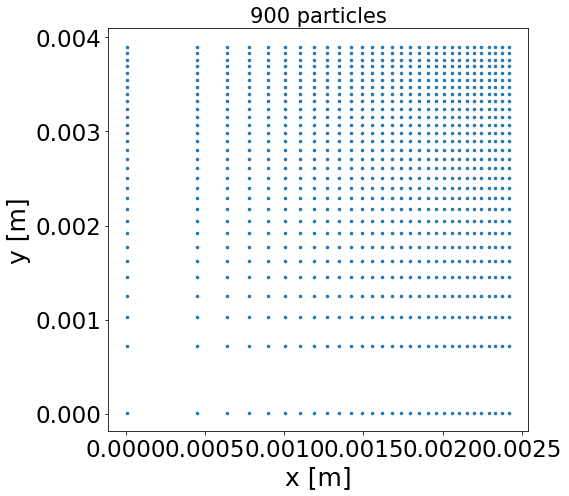

In [9]:
plt.plot(bunch.x, bunch.y, '.')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('{} particles'.format(macroparticlenumber))
plt.tight_layout()
savefig = False
if savefig:
    plt.plot('initial_distribution.png')

### Create the maps

In [10]:
### CREATE THE TRANSVERSE MAP
transverse_map = TransverseMap(s, alpha_x, beta_x, D_x, alpha_y, beta_y, D_y, Q_x, Q_y,
    [Chromaticity(Qp_x, Qp_y),
    AmplitudeDetuning(app_x, app_y, app_xy)]) 


### CREATE THE LONGITUDINAL MAP
longitudinal_map = LinearMap([alpha], circumference, Q_s)

### Set up the accelerator map and start tracking

In [11]:
t0 = time.clock()

#reload object from file
file2 = open('bunch', 'rb')
bunch = pickle.load(file2)
file2.close()

print('--> Begin tracking...')
one_turn_map = [transverse_map[0]] + [longitudinal_map]
n_damped_turns = int(n_turns/decTurns) # The total number of turns at which the data are damped.
                       # We want this number as an integer, so it can be used in the next functions. 
X = []
Y = []
XP = []
YP = []
sigma = []
delta = []
    
for i in range(n_turns):
    
   #These next two lines actually "run" the simulation - the computationally heavy part
    for m in one_turn_map:
        m.track(bunch)
            
    X.append(bunch.x)
    Y.append(bunch.y)
    XP.append(bunch.xp)
    YP.append(bunch.yp)
    sigma.append(bunch.z)
    delta.append(bunch.dp)

        
dataExport = [X, Y, XP, YP, sigma, delta]
f = open(filename, 'w')

with f:
    out = csv.writer(f, delimiter=',')
    out.writerows(zip(*dataExport))

print('--> Done.')

print("Simulation time in seconds: " + str(time.clock() - t0))

/home/natalia/anaconda3/envs/run_pyheadtail/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


--> Begin tracking...
--> Done.
Simulation time in seconds: 36.490353999999996


/home/natalia/anaconda3/envs/run_pyheadtail/lib/python3.7/site-packages/ipykernel_launcher.py:42: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


### Organise you data
- The tbt data obtained from the simulation are grouped with respect to turns.
- We need to group them in a list for each particle.

In [12]:
x_data = {}
px_data = {}
y_data = {}
py_data = {}
for particle in range(macroparticlenumber):
    x_data[particle] = []
    px_data[particle] = []
    y_data[particle] = []
    py_data[particle] = []

In [13]:
# maybe even 100 turns are enough
for particle in range(macroparticlenumber):
    for turn in range(n_turns):
        x_data[particle].append(X[turn][particle])
        px_data[particle].append(XP[turn][particle])
        y_data[particle].append(Y[turn][particle])
        py_data[particle].append(YP[turn][particle])

### Compute the tune
- Identify wheather there are any lost particles.
- If not compute the tune (from the tbt data using NAFF)

In [14]:
x_lost_particles = []
Qx_list = []
y_lost_particles = []
Qy_list = []

for particle in range(macroparticlenumber):
    if np.isnan(x_data[particle]).any() or np.isnan(px_data[particle]).any():
        x_lost_particles.append(particle)
        print('particle {} lost'.format(particle))
    else:        
        signal_x = x_data[particle]
        Qx_list.append(pnf.get_tune(np.array(signal_x)))
        
    if np.isnan(y_data[particle]).any() or np.isnan(py_data[particle]).any():
        y_lost_particles.append(particle)
        print('particle {} lost'.format(particle))
    else:        
        signal_y = y_data[particle]
        Qy_list.append(pnf.get_tune(np.array(signal_y)))

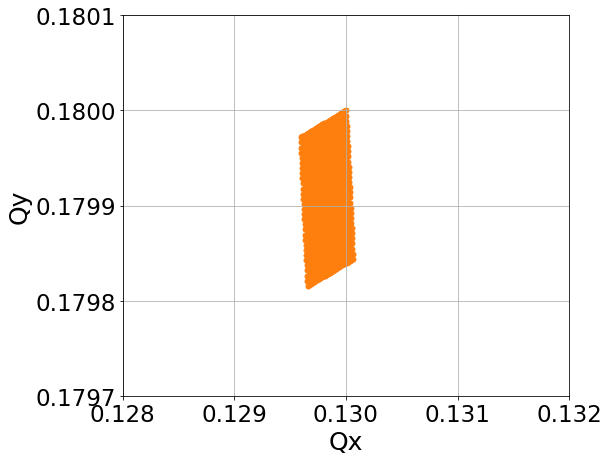

In [18]:
plt.scatter(Qx_list, Qy_list, c='C1')
plt.ylim(0.1797, 0.1797+0.0004)
plt.xlim(0.128, 0.128+0.004)
plt.grid()
plt.xlabel('Qx')
plt.ylabel('Qy')
savefig = False
if savefig:
    plt.savefig('footprint_pyheadtail.png')

###  Save the tunes in a pickle

In [19]:
my_tunes = {'Qx':Qx_list, 'Qy':Qy_list}
pickle.dump(my_tunes, open('tunes_pyheadtail.pkl', 'wb'))